<a href="https://colab.research.google.com/github/jodejetalo99/Introduccion-al-Aprendizaje-Profundo/blob/main/Proyecto/Proyecto_IAPP_JJTL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# Proyecto: Conteo y clasificación por audio (Basado en redes convolucionales y espectogramas)

## Integrantes:
- Martiñón Luna Jonathan José
- Tapia López José de Jesús

## Licenciatura en Ciencia de Datos
## Universidad Nacional Autónoma de México 



---

# Librerías

---


In [1]:
# Colab
! pip install torchinfo
try:
    import torchaudio
except:
    ! pip install torchaudio

     |████████████████████████████████| 1.9MB 4.2MB/s 


In [77]:
# funciones aleatorias
import random
# arreglos multidimensionales
import numpy as np
from google.colab import drive
import pandas as pd
# Graficos
import matplotlib.pyplot as plt
# tomar n elementos de una secuencia
from itertools import islice as take

# Audios
from scipy.io import wavfile
import librosa
import librosa.display
import IPython as ip

# reproductor
import IPython as ip
# gráficas
import matplotlib.pyplot as plt
# arreglos multidimensionales
import numpy as np

# redes neuronales
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
# redes audio
import torchaudio
import torchaudio.transforms as T
# redes visión
import torchvision.models as tvm

# redes neuronales
from torch.utils.data import DataLoader
# inspección de arquitectura
from torchinfo import summary

# barras de progreso
from tqdm.auto import trange

---

# Funciones

---


In [59]:
CLASES = {0:'1 hablante', 1:'2 hablantes', 2:'hablantes'}


def set_seed(seed=0):
    """Initializes pseudo-random number generators."""
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)

    
# reproducibilidad
set_seed()

---

# Pre-procesamiento

---


## Descarga de datos

Montamos drive, para realizar la extracción de los datos a utilizar.

In [5]:
drive.mount('/content/drive/')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.activity.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fexperimentsandconfigs%20https%3a%2f%2fwww.googleapis.com%2fauth%2fphotos.native&response_type=code

Enter your authorization code:
4/1AY0e-g5wBycS51C0yblFKDCBvY-D6qZO1qt33VL-M6ZVIq1lqGa9yp3RpV0
Mounted at /content/drive/


Movemos los archivos a una carpeta específica (`./Data`), para no tener que buscarlos o ingresar la dirección completa

In [ ]:
#!rm -r "Data"

In [6]:
!mkdir "./Data"
!cp "drive/MyDrive/Intro_Ap_Prof/Proyecto/Validacion.csv" "Data"
!cp "drive/MyDrive/Intro_Ap_Prof/Proyecto/Entrenamiento.csv" "Data"
!cp "drive/MyDrive/Intro_Ap_Prof/Proyecto/Prueba.csv" "Data"

In [7]:
!unzip -q "drive/My Drive/Intro_Ap_Prof/Proyecto/Audios_Prueba.zip" -d "./Data"
!unzip -q "drive/My Drive/Intro_Ap_Prof/Proyecto/Audios_Validacion.zip" -d "./Data"
!unzip -q "drive/My Drive/Intro_Ap_Prof/Proyecto/Audio_Entrenamiento.zip" -d "./Data"

Una vez que ya contamos con los archivos necesarios, procedemos a desmontar nuestro drive.

In [ ]:
drive.flush_and_unmount()

In [ ]:
! ls -R {'Data'} | head -20

Data:
Entrenamiento
Entrenamiento.csv
Prueba
Prueba.csv
Validacion
Validacion.csv

Data/Entrenamiento:
Audio_Train0.wav
Audio_Train10000.wav
Audio_Train10001.wav
Audio_Train10002.wav
Audio_Train10003.wav
Audio_Train10004.wav
Audio_Train10005.wav
Audio_Train10006.wav
Audio_Train10007.wav
Audio_Train10008.wav
Audio_Train10009.wav


## Lectura de datos

In [8]:
entrenamiento_df = pd.read_csv("./Data/Entrenamiento.csv")
validacion_df = pd.read_csv("./Data/Validacion.csv")
prueba_df = pd.read_csv("./Data/Prueba.csv")

### Datasets

In [19]:
print(f"Contamos con {str(entrenamiento_df.shape[0])[:3]},{str(entrenamiento_df.shape[0])[3:]} datos de Entrenamiento.")
# cambiamos las etiquetas para que empiecen desde 0
# 0: 1 hablante
# 1: 2 hablantes
# 2: 3 hablantes
entrenamiento_df['Speakers_Class'] = entrenamiento_df['Speakers'] - 1
entrenamiento_df.head()


Contamos con 100,000 datos de Entrenamiento.


,Waveform,Speakers,Speakers_Sex,F,M,Speakers_Class
0,[-0.00354004 -0.00354004 -0.00372314 ... 0.00...,1,F,1,0,0
1,[-0.05560303 -0.03948975 -0.01425171 ... 0.06...,1,M,0,1,0
2,[0.08041382 0.10652161 0.13059998 ... 0.017501...,2,FF,2,0,1
3,[0.00216675 0.00177002 0.00131226 ... 0.022705...,1,M,0,1,0
4,[ 0.0064799 0.00262451 0.00343831 ... -0.00...,3,FFF,3,0,2


In [20]:
print(f"Contamos con {str(validacion_df.shape[0])[:2]},{str(validacion_df.shape[0])[2:]} datos de Validación.")
# cambiamos las etiquetas para que empiecen desde 0
# 0: 1 hablante
# 1: 2 hablantes
# 2: 3 hablantes
validacion_df['Speakers_Class'] = validacion_df['Speakers'] - 1

validacion_df.head()

Contamos con 10,000 datos de Validación.


,Waveform,Speakers,Speakers_Sex,F,M,Speakers_Class
0,[ 0.0045166 0.00930786 -0.00366211 ... 0.02...,1,M,0,1,0
1,[ 0.02026367 0.02442932 0.02787781 ... -0.00...,2,MM,0,2,1
2,[-0.03646851 -0.03983561 -0.04340617 ... -0.03...,3,MMF,1,2,2
3,[ 0.02868652 0.0123291 0.00295003 ... -0.02...,3,MMM,0,3,2
4,[0.01849365 0.02142334 0.01538086 ... 0.020345...,3,MMM,0,3,2


In [21]:
print(f"Contamos con {str(prueba_df.shape[0])[:2]},{str(prueba_df.shape[0])[2:]} datos de prueba.")
# cambiamos las etiquetas para que empiecen desde 0
# 0: 1 hablante
# 1: 2 hablantes
# 2: 3 hablantes
prueba_df['Speakers_Class'] = prueba_df['Speakers'] - 1
prueba_df.head()

Contamos con 10,000 datos de prueba.


,Waveform,Speakers,Speakers_Sex,F,M,Speakers_Class
0,[ 0.00117493 0.00216675 0.0037384 ... -0.01...,2,MF,1,1,1
1,[-3.0517578e-05 1.8310547e-04 2.5939941e-04 ...,2,MF,1,1,1
2,[-0.03262329 -0.03387451 -0.03366089 ... 0.00...,1,M,0,1,0
3,[-0.03912354 -0.02819824 -0.02289836 ... -0.10...,3,MMM,0,3,2
4,[ 0.00628662 0.01490784 0.01811218 ... -0.01...,2,MF,1,1,1


### Conjunto de datos

In [32]:
# directorio de datos
DATA_DIR = 'Data'

# tamaño del lote
BATCH_SIZE = 32

# parámetros de audio
SECS = 1
SAMPLE_RATE = 16000

In [52]:
def identity(x):
    return x

class Audios:

    def __init__(self, subset, dataframe, cantidad_datos, sample_rate):
        self.subset = 'Data/'+subset
        self.sample_rate = sample_rate
        self.cantidad_datos = cantidad_datos
        # self.subsubset = 'Data/'+subset+'/'+subsubset
        
        if self.subset == 'Data/Entrenamiento':
          self.audios = [wavfile.read(self.subset+'/Audio_Train'+str(i)+'.wav')[1].reshape(1,-1) for i in range(self.cantidad_datos)]
        elif self.subset == 'Data/Validacion':
          self.audios = [wavfile.read(self.subset+'/Audio_Validation'+str(i)+'.wav')[1].reshape(1,-1) for i in range(self.cantidad_datos)]
        else:
          self.audios = [wavfile.read(self.subset+'/Audio_Test'+str(i)+'.wav')[1].reshape(1,-1) for i in range(self.cantidad_datos)]

        # leemos el df que contiene a los metadatos
        self.df = dataframe

        # guardamos nuestra clase correspondiente al numero de hablantes como int
        self.speakers_class = self.df['Speakers_Class'].tolist()

    def __getitem__(self, i):
        # cargamos el audio
        audio_i = self.audios[i]
        # cargamos sus metadatos
        # guardamos numero de hablantes como int
        speakers_class_i = self.speakers_class[i]
        # sample_rate
        sample_rate_i = self.sample_rate
        return audio_i, speakers_class_i, sample_rate_i

    def __len__(self):
        # regresamos numeros de ejemplos
        return len(self.audios)


 ### Cargador de datos

In [53]:
def build_dl(subset, dataframe, SAMPLE_RATE=16000, BATCH_SIZE=32, shuffle=False):

   # creamos un Dataset
    ds = Audios(
        subset, #subconjunto de datos
        dataframe,
        10000, # cantidad de datos del subconjunto
        SAMPLE_RATE # en todos es de 16000
        )

    # creamos un DataLoader
    dl = DataLoader(
        # conjunto
        ds,
        # tamaño del lote
        batch_size=BATCH_SIZE,
        # barajear
        shuffle=shuffle,
    )
    return dl

#### Entrenamiento

x shape=torch.Size([32, 1, 16000]) dtype=torch.float32
y shape=torch.Size([32]) dtype=torch.int64


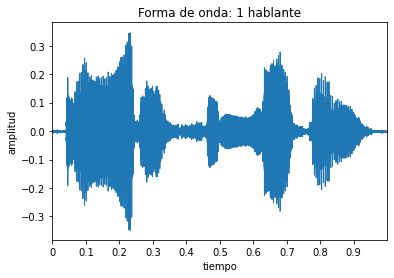

In [69]:
dl = build_dl(subset='Entrenamiento', dataframe = entrenamiento_df)

# desplegamos un lote de audios
x, y, sr = next(iter(dl))
print(f'x shape={x.shape} dtype={x.dtype}')
print(f'y shape={y.shape} dtype={y.dtype}')

# inspeccionemos un ejemplo
waveform = x[0].squeeze().numpy()
label = CLASES[y[0].item()]

# grafiquemos forma de onda
librosa.display.waveplot(waveform, sr=SAMPLE_RATE)
plt.title(f'Forma de onda: {label}')
plt.xlabel('tiempo')
plt.ylabel('amplitud')
plt.show()

# reproductor
ip.display.Audio(waveform, rate=SAMPLE_RATE)

#### Validación

x shape=torch.Size([32, 1, 16000]) dtype=torch.float32
y shape=torch.Size([32]) dtype=torch.int64


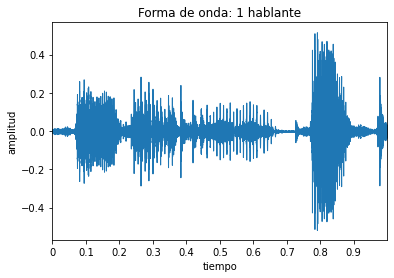

In [68]:
dl = build_dl(subset='Validacion', dataframe = validacion_df)

# desplegamos un lote de audios
x, y, sr = next(iter(dl))
print(f'x shape={x.shape} dtype={x.dtype}')
print(f'y shape={y.shape} dtype={y.dtype}')

# inspeccionemos un ejemplo
waveform = x[0].squeeze().numpy()
label = CLASES[y[0].item()]

# grafiquemos forma de onda
librosa.display.waveplot(waveform, sr=SAMPLE_RATE)
plt.title(f'Forma de onda: {label}')
plt.xlabel('tiempo')
plt.ylabel('amplitud')
plt.show()

# reproductor
ip.display.Audio(waveform, rate=SAMPLE_RATE)

# Ciclo de entrenamiento



In [78]:
def train_epoch(dl, model, opt, device):

    # por cada lote
    for x, y_true, *_ in dl:

        # movemos a dispositivo
        x = x.to(device)
        y_true = y_true.to(device)

        # computamos logits
        y_lgts = model(x)

        # computamos la pérdida
        loss = F.cross_entropy(y_lgts, y_true)

        # vaciamos los gradientes
        opt.zero_grad()

        # retropropagamos
        loss.backward()

        # actualizamos parámetros
        opt.step()


def eval_epoch(dl, model, device, num_batches=None):

    # evitamos que se registren las operaciones 
    # en la gráfica de cómputo
    with torch.no_grad():

        # historiales
        losses, accs = [], []

        # validación de la época con num_batches
        # si num_batches==None, se usan todos los lotes
        for x, y_true, *_ in take(dl, num_batches):

            # movemos a dispositivo
            x = x.to(device)
            y_true = y_true.to(device)

            # computamos los logits
            y_lgts = model(x)

            # computamos los puntajes
            y_prob = F.softmax(y_lgts, 1)

            # computamos la clases
            y_pred = torch.argmax(y_prob, 1)

            # computamos la pérdida
            loss = F.cross_entropy(y_lgts, y_true)

            # computamos la exactitud
            acc = (y_true == y_pred).type(torch.float32).mean()

            # guardamos históricos
            losses.append(loss.item())
            accs.append(acc.item())

        # promediamos
        loss = np.mean(losses) * 100
        acc = np.mean(accs) * 100

        return loss, acc
        
        
def train(model, trn_dl, tst_dl, lr=1e-4, epochs=20,
          trn_batches=None, tst_batches=None):

    # historiales
    loss_hist, acc_hist = [], []
    
    # optimizador
    opt = optim.Adam(model.parameters(), lr=lr)

    # usamos GPU si está disponible
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    # movemos a dispositivo
    model.to(device)

    # ciclo de entrenamiento
    for epoch in trange(epochs):

        # modelo en modo de entrenamiento
        model.train()
        # entrenamos la época
        train_epoch(trn_dl, model, opt, device)

        # modelo en modo de evaluación
        model.eval()
        # evaluamos la época en entrenamiento
        trn_loss, trn_acc = eval_epoch(trn_dl, model, device, trn_batches)
        # evaluamos la época en prueba
        tst_loss, tst_acc = eval_epoch(tst_dl, model, device, tst_batches)

        # guardamos historial
        loss_hist.append([trn_loss, tst_loss])
        acc_hist.append([trn_acc, tst_acc])

        # imprimimos progreso
        print(f'E{epoch:02} '
              f'loss=[{trn_loss:6.2f},{tst_loss:6.2f}] '
              f'acc=[{trn_acc:5.2f},{tst_acc:5.2f}]')

    return loss_hist, acc_hist

# Arquitectura

El siguiente diseño es una versión simplificada de la arquitectura M5 presentada [ Dai. y col. en Very Deep Convolutional Neural Networks for Raw Waveforms](https://arxiv.org/abs/1610.00087)



In [79]:
class M5B2(nn.Module):

    def __init__(self, n_in_channels=1, n_classes=3, 
                 stride=16, n_channel=32):
        super().__init__()

        self.cnn = nn.Sequential(

            # bloque conv 1
            nn.Conv1d(in_channels=n_in_channels, 
                      out_channels=n_channel, 
                      kernel_size=80, stride=stride),
            nn.BatchNorm1d(num_features=n_channel),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=4, stride=4),

            # bloque conv 2
            nn.Conv1d(in_channels=n_channel, 
                      out_channels=n_channel, 
                      kernel_size=3),
            nn.BatchNorm1d(num_features=n_channel),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=4, stride=4),

        )

        self.pool = nn.AdaptiveAvgPool1d(1)
        self.flat = nn.Flatten()
        self.fc = nn.Linear(n_channel, n_classes)


    def forward(self, x):
        x = self.cnn(x)
        x = self.pool(x)
        x = self.flat(x)
        x = self.fc(x)
        return x


def build_m5b2():
    return M5B2()

m5b2 = build_m5b2()
m5b2

M5B2(
  (cnn): Sequential(
    (0): Conv1d(1, 32, kernel_size=(80,), stride=(16,))
    (1): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool1d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
    (4): Conv1d(32, 32, kernel_size=(3,), stride=(1,))
    (5): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): MaxPool1d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  )
  (pool): AdaptiveAvgPool1d(output_size=1)
  (flat): Flatten(start_dim=1, end_dim=-1)
  (fc): Linear(in_features=32, out_features=3, bias=True)
)

In [80]:
x = torch.zeros(1, 1, 16000)
y = m5b2(x)
print(f'{x.shape} => {y.shape}')

torch.Size([1, 1, 16000]) => torch.Size([1, 3])


In [81]:
summary(m5b2, (1, 1, 16000), device='cpu', verbose=0,
        col_names=['input_size', 'output_size', 'num_params'])

Layer (type:depth-idx)                   Input Shape               Output Shape              Param #
M5B2                                     --                        --                        --
├─Sequential: 1-1                        [1, 1, 16000]             [1, 32, 61]               --
│    └─Conv1d: 2-1                       [1, 1, 16000]             [1, 32, 996]              2,592
│    └─BatchNorm1d: 2-2                  [1, 32, 996]              [1, 32, 996]              64
│    └─ReLU: 2-3                         [1, 32, 996]              [1, 32, 996]              --
│    └─MaxPool1d: 2-4                    [1, 32, 996]              [1, 32, 249]              --
│    └─Conv1d: 2-5                       [1, 32, 249]              [1, 32, 247]              3,104
│    └─BatchNorm1d: 2-6                  [1, 32, 247]              [1, 32, 247]              64
│    └─ReLU: 2-7                         [1, 32, 247]              [1, 32, 247]              --
│    └─MaxPool1d: 2-8        

### Entrenamiento

In [82]:
def train_model(build_model, lr=1e-4, epochs=20):
    set_seed()
    trn_dl = build_dl(subset='Entrenamiento', dataframe = entrenamiento_df)
    val_dl = build_dl(subset='Validacion', dataframe = validacion_df)
    model = build_model()
    loss_hist, acc_hist = train(
        model, trn_dl, val_dl, lr=lr, epochs=epochs)



In [83]:
train_model(build_model=build_m5b2)

E00 loss=[ 99.62,101.32] acc=[53.70,51.31]
E01 loss=[ 95.44, 97.47] acc=[58.30,56.63]
E02 loss=[ 93.01, 95.85] acc=[59.53,57.27]
E03 loss=[ 90.76, 94.36] acc=[61.37,58.15]
E04 loss=[ 88.56, 93.06] acc=[63.06,58.87]
E05 loss=[ 86.25, 91.68] acc=[64.49,60.19]
E06 loss=[ 83.91, 90.53] acc=[65.79,61.33]
E07 loss=[ 81.11, 89.54] acc=[66.69,61.97]
E08 loss=[ 78.50, 87.96] acc=[67.85,63.53]
E09 loss=[ 76.46, 86.78] acc=[68.69,64.70]
E10 loss=[ 74.23, 85.16] acc=[69.36,65.68]
E11 loss=[ 72.66, 83.88] acc=[69.77,66.62]
E12 loss=[ 71.45, 83.06] acc=[69.97,67.11]
E13 loss=[ 70.47, 82.72] acc=[70.30,67.36]
E14 loss=[ 69.59, 82.24] acc=[70.65,67.77]
E15 loss=[ 68.73, 81.30] acc=[70.83,68.48]
E16 loss=[ 67.90, 80.59] acc=[71.27,68.84]
E17 loss=[ 67.27, 80.22] acc=[71.31,69.12]
E18 loss=[ 66.92, 80.50] acc=[71.56,69.13]
E19 loss=[ 66.28, 80.06] acc=[71.76,69.46]

